# Example Notebook for PySpark

This is an example notebook that goes through some Pyspark stuff.  It follows [this datacamp tutorial](https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark).

In [18]:
# Getting the data: standard "Online Retail" dataset.
# Using a CSV link for it, for simplicity.
# Ref: https://archive.ics.uci.edu/dataset/352/online+retail
!curl -so retail.csv https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/retail-data/all/online-retail-dataset.csv

`SparkSession`s are the entrypoint into all functionality in Spark.  You wanna build a dataframe?  Gott'a make a `SparkSession`!

In [90]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import VectorAssembler, StandardScaler

In [9]:
spark = (
    SparkSession.builder
    .appName("Example")
    .config("spark.memory.offHeap.enabled","true")
    .config("spark.memory.offHeap.size","10g")
).getOrCreate()

In [19]:
# Create a Dataframe.
df = spark.read.csv("retail.csv", header=True, escape="\"")

In [47]:
rows = 5
truncate_vals = 0  # Set to a number > 0 to truncate values.

df.show(rows, truncate_vals)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------

In [134]:
# Do some EDA!
print(df.count())  # 541909

# How many unique customers?
print(df.select("CustomerID").distinct().count())  # 4373

# Where do most purchases come from?
df_by_country_distinct_customers = (
    df.groupBy("Country")
      .agg(countDistinct("CustomerID").alias("country_count"))
)

## Unordered.
df_by_country_distinct_customers.show(5, 0)

## Ordered.
df_by_country_distinct_customers.orderBy(desc("country_count")).show(5, 0)

# Most recent purchase?
# We need to convert the InvoiceData col into a timestamp format.
df1 = df.withColumn('InvoiceDT', to_timestamp(col("InvoiceDate"), "M/d/yyyy H:m"))
df1 = df1.drop("InvoiceDate")
df1.select(max("InvoiceDT")).show(5, 0)


541909
4373
+---------+-------------+
|Country  |country_count|
+---------+-------------+
|Sweden   |8            |
|Singapore|1            |
|Germany  |95           |
|RSA      |1            |
|France   |87           |
+---------+-------------+
only showing top 5 rows

+--------------+-------------+
|Country       |country_count|
+--------------+-------------+
|United Kingdom|3950         |
|Germany       |95           |
|France        |87           |
|Spain         |31           |
|Belgium       |25           |
+--------------+-------------+
only showing top 5 rows

+-------------------+
|max(InvoiceDT)     |
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [141]:
# Deriving New Features (Preprocessing)
df2 = df1.alias("df2")  # copy the df for convenience in the notebook.

# Earliest Date
df2 = df2.withColumn("from_date", lit(df2.select(min("InvoiceDT")).collect()[0][0]))
df2 = df2.withColumn('from_date', to_timestamp("from_date", 'm/d/yyyy h:MM'))

df2 = (
    df2.withColumn('from_date', to_timestamp(col('from_date')))
       .withColumn('MostRecentPurchaseTime', col("InvoiceDT").cast("long") - col('from_date').cast("long"))
)
df2 = df2.join(df2.groupBy('CustomerID').agg(max('MostRecentPurchaseTime').alias('MostRecentPurchaseTime')),on='MostRecentPurchaseTime',how='leftsemi')
df2 = df2.drop("from_date")

df2_customer_frequency = df2.groupBy("CustomerID").agg(count("InvoiceDT").alias("Frequency"))
df2 = df2.join(df2_customer_frequency, on="CustomerID", how="inner")

df_total_amt = df2.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))
df_total_amt_gp = df_total_amt.groupby("CustomerID").agg(sum("TotalAmount").alias("CustomerValue"))
df2 = df2.join(df_total_amt_gp, on="CustomerID", how="inner")

df2.show(5, 10)

+----------+----------------------+---------+---------+-----------+--------+---------+----------+----------+---------+-------------+
|CustomerID|MostRecentPurchaseTime|InvoiceNo|StockCode|Description|Quantity|UnitPrice|   Country| InvoiceDT|Frequency|CustomerValue|
+----------+----------------------+---------+---------+-----------+--------+---------+----------+----------+---------+-------------+
|     17551|               1230360|   539019|   46000P| POLYEST...|       4|     4.25|United ...|2010-12...|       43|       306.84|
|     17551|               1230360|   539019|   82494L| WOODEN ...|       1|     2.95|United ...|2010-12...|       43|       306.84|
|     17551|               1230360|   539019|    21232| STRAWBE...|       1|     1.25|United ...|2010-12...|       43|       306.84|
|     17551|               1230360|   539019|    22693| GROW A ...|      24|     1.25|United ...|2010-12...|       43|       306.84|
|     17551|               1230360|   539019|   84536A| ENGLISH...|  

In [142]:
# Select only the columns we need for a model.
df3 = df2.select(["CustomerID", "MostRecentPurchaseTime", "Frequency", "CustomerValue"]).distinct()
df3.show(5,0)

+----------+----------------------+---------+------------------+
|CustomerID|MostRecentPurchaseTime|Frequency|CustomerValue     |
+----------+----------------------+---------+------------------+
|17551     |1230360               |43       |306.84            |
|13187     |3148260               |37       |236.01999999999995|
|17128     |3382560               |14       |157.09            |
|17855     |91080                 |17       |208.96999999999997|
|12386     |3125460               |2        |143.0             |
+----------+----------------------+---------+------------------+
only showing top 5 rows



In [150]:
# Scale the columns!
features = ["MostRecentPurchaseTime", "Frequency", "CustomerValue"]

assemble = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assemble.transform(df3)  # Makes a "features" column with array values.

scale = StandardScaler(inputCol="features", outputCol="standardized")
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

data_scale_output.select(["features", "standardized"]).show(5,0)

+-----------------------------------+--------------------------------------------------------------+
|features                           |standardized                                                  |
+-----------------------------------+--------------------------------------------------------------+
|[1230360.0,43.0,306.84]            |[0.14106530839131146,1.110248323079232,0.10976640103961076]   |
|[3148260.0,37.0,236.01999999999995]|[0.36095961165514984,0.9553299524170135,0.0844318406119441]   |
|[3382560.0,14.0,157.09]            |[0.3878229701486674,0.36147619821184296,0.05619607593310017]  |
|[91080.0,17.0,208.96999999999997]  |[0.010442657667902602,0.43893538354295214,0.07475519757934904]|
|[3125460.0,2.0,143.0]              |[0.35834550762761164,0.051639456887406135,0.05115563599486488]|
+-----------------------------------+--------------------------------------------------------------+
only showing top 5 rows



In [159]:
# Building the Model!
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# Making a K-Means alg.
cost = []
evaluator = ClusteringEvaluator(
    predictionCol="prediction", 
    featuresCol="standardized",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

for _k in range(2, 10):
    KMeans_algo = KMeans(featuresCol="standardized", k=_k)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost.append({"k": _k, "training_cost": KMeans_fit.summary.trainingCost})

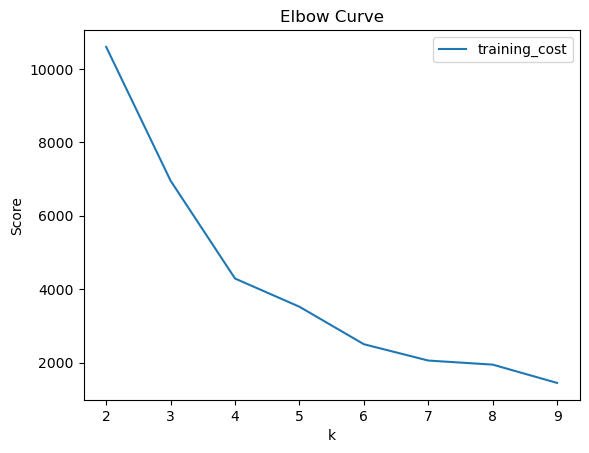

In [168]:
# Checkin' out the metrics.
import pandas as pd
import matplotlib.pyplot as plt

df_cost = pd.DataFrame(cost)

f, ax = plt.subplots(1)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Score")
ax.set_title("Elbow Curve")
_p = df_cost.plot(x="k", y="training_cost", ax=ax)

# k = 4 looks pretty good!

In [170]:
# Build the model using our k=4 val from above!
KMeans_algo = KMeans(featuresCol="standardized", k=4)
KMeans_fit = KMeans_algo.fit(data_scale_output)

In [174]:
# Predict!
preds = KMeans_fit.transform(data_scale_output)
preds.select(["CustomerID", "MostRecentPurchaseTime", "Frequency", "CustomerValue", "Prediction"]).show(20, 0)

+----------+----------------------+---------+-------------------+----------+
|CustomerID|MostRecentPurchaseTime|Frequency|CustomerValue      |Prediction|
+----------+----------------------+---------+-------------------+----------+
|17551     |1230360               |43       |306.84             |1         |
|13187     |3148260               |37       |236.01999999999995 |1         |
|17128     |3382560               |14       |157.09             |1         |
|17855     |91080                 |17       |208.96999999999997 |1         |
|12386     |3125460               |2        |143.0              |1         |
|13065     |30360                 |14       |205.85999999999999 |1         |
|16510     |105180                |13       |248.10000000000002 |1         |
|17303     |1055160               |53       |250.03999999999994 |1         |
|15899     |439800                |4        |56.25              |1         |
|16519     |30093300              |13       |215.08             |0         |

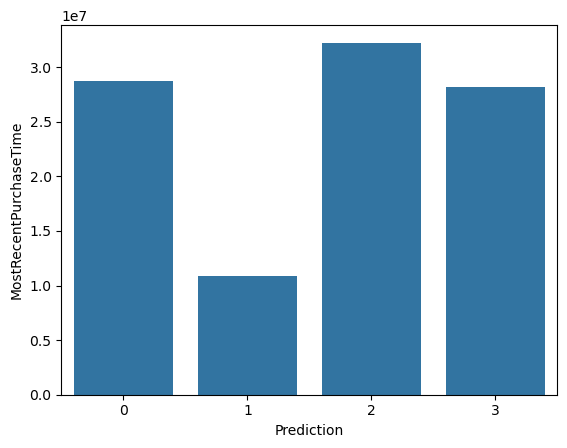

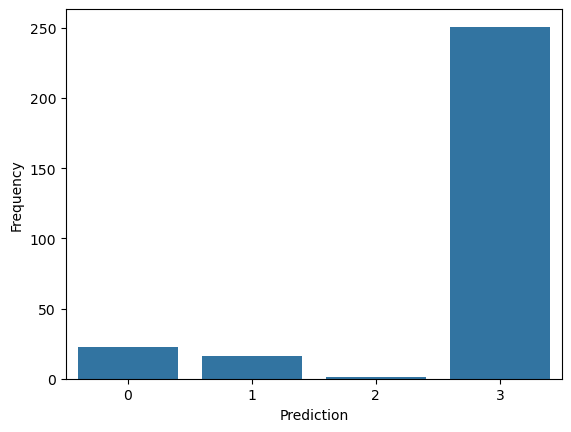

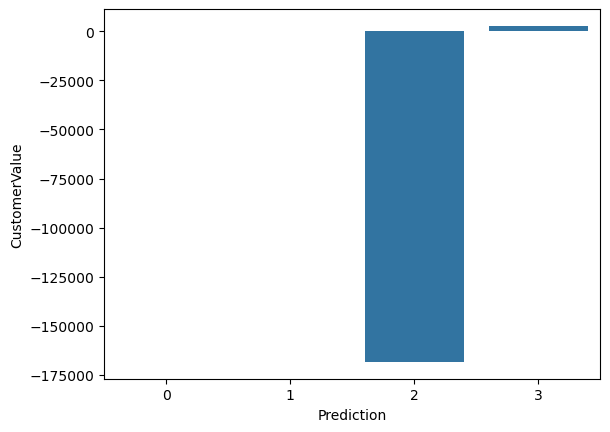

In [179]:
# Doin' some cluster analysis.
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select(["CustomerID", "MostRecentPurchaseTime", "Frequency", "CustomerValue", "Prediction"])
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(["Prediction"], as_index=False).mean()

feature_col = ["MostRecentPurchaseTime", "Frequency", "CustomerValue"]

for feature in feature_col:
    sns.barplot(x="Prediction", y=feature, data=avg_df)
    plt.show()

In [180]:
# Some followups: 
# - Why is the customer value so skewed, and so negative?